# Задание 2

#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

## Импорт данных

In [1]:
import pandas as pd
from urllib.parse import urlencode
import requests

import seaborn as sns

from scipy.stats import kstest
from scipy.stats import fligner
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
final_url = base_url + urlencode(dict(public_key=public_key))

In [3]:
data = pd.read_csv(requests.get(final_url).json()['href'], sep=';')

In [4]:
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


### Предварительный анализ

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
# Проверка наличия дубликатов в данных
data.duplicated().sum()

0

Видим, что в данных нет отсутствующих значений и дубликатов. Тип колонок соответствует содержимому.

## Решение

##### 1. Для ответа на вопросы задания проанализируем покупки пользователей (revenue > 0) в каждой из групп по отдельности. Сравним минальные и максимальные суммы покупок и их распределение.
##### 2. Известно, что ARPU в тестовой группе увеличился на 5 процентов. Проверим, является ли это изменение статистически значимым. Таже проверим изменились ли такие метрики, как ARPPU (средний доход на платящего клиента) и конверсия (CR).

### 1. Анализ групп

In [7]:
data.query('testgroup == "a" and revenue > 0').describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


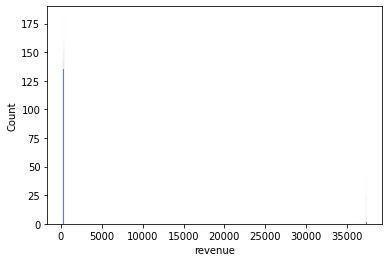

In [8]:
sns.histplot(data.query('testgroup == "a" and revenue > 0').revenue, kde = False)

In [9]:
data.query('testgroup == "b" and revenue > 0').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


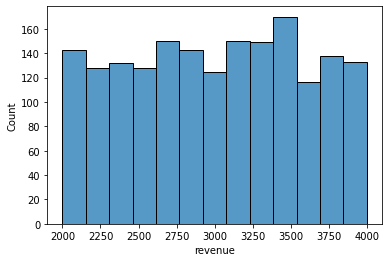

In [10]:
sns.histplot(data.query('testgroup == "b" and revenue > 0').revenue, kde = False)

В группе А максимальная сумма покупки сильно отличается от 75 перцентиля. На графике также видно, что бОльшая часть покупок с суммой до 5000. В то время, как в группе В нет заметных различий между покупками. 

Разделим группу А на две части по сумме покупок и посмотрим подробнее на каждую из них.

In [11]:
data.query('testgroup == "a" and revenue > 0 and revenue > 5000').describe()

,user_id,revenue
count,123.000000,123.000000
mean,203513.073171,37319.121951
std,116745.137742,25.442183
min,417.000000,37293.000000
25%,109013.500000,37301.000000
50%,204560.000000,37311.000000
75%,317108.500000,37329.000000
max,399295.000000,37433.000000


Всего 123 игрока свыше 5000, нет оснований считать это выбросами.

In [12]:
data.query('testgroup == "a" and revenue > 0 and revenue < 5000').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,199923.686981,302.458172
std,116615.234772,57.914246
min,73.000000,200.000000
25%,98963.000000,254.000000
50%,199268.000000,305.000000
75%,298918.000000,352.000000
max,404768.000000,400.000000


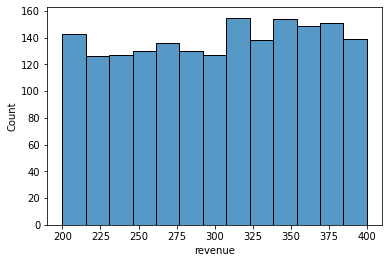

In [13]:
sns.histplot(data.query('testgroup == "a" and revenue > 0 and revenue < 5000').revenue, kde = False)

Мы видим четкое разделение пользователей группы А:
 - 123 (7%) пользователя с суммой покупок от 37293 до 37433;
 - 1805 (93%) пользователей с суммой покупок от 200 до 400.
 
Это либо очень дорогие покупки, либо очень дешевые. Нет ни одного пользователя с чеком в среднем ценовом диапазоне.  
 
В то время, как в группе В - 1805 (100%) пользователей с суммой покупок 2000 до 4000. Но нет ни одной дорогой или дешевой покупки. 

Мы наблюдаем слишком разный характер покупок у пользователей. Возможно, разделение на группы было проведено не корректно.

### 2. Анализ метрик

#### ARPU (Average revenue per user) - cредний доход с привлечённого пользователя

Проверим нормально ли распределены данные. Выборки большие, поэтому буду использовать критерий Колмогорова-Смирнова.
- H0 - распределение нормальное
- H1 - распределение не нормальное
- уровень значимости 0,05

In [14]:
# уровень значимости для проверки (далее испольузется во всех тестах)
alpha = 0.05

In [15]:
revenue_a = data.query('testgroup == "a"').revenue
revenue_b = data.query('testgroup == "b"').revenue

In [16]:
 # расчет p-value для контрольной группы
statistic_a, p_value_a = kstest(revenue_a, 'norm', args=(revenue_a.mean(), revenue_a.std()))

print("Статистика:", statistic_a)
print("p-значение:", p_value_a)

if p_value_a > alpha: 
    print("Не отвергаем нулевую гипотезу, данные подчиняются нормальному распределению.")
else:
    print("Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.")

Статистика: 0.5014699438603156
p-значение: 0.0
Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.


In [17]:
 # расчет p-value для тестовой группы
statistic_b, p_value_b = kstest(revenue_b, 'norm', args=(revenue_b.mean(), revenue_b.std()))

print("Статистика:", statistic_b)
print("p-значение:", p_value_b)

if p_value_b > alpha:   
    print("Не отвергаем нулевую гипотезу, данные подчиняются нормальному распределению.")
else:
    print("Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.")

Статистика: 0.5281836512609979
p-значение: 0.0
Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.


Данные не распределены нормально, поэтому для проверки гомогенности дисперсий между группами данных буду использовать тест Флигнера-Килина.
- H0 - дисперсии в группах гомогенны
- H1 - дисперсии в группах не гомогенны
- alpha - уровень значимости 0,05

In [18]:
statistic, p_value = fligner(revenue_a, revenue_b)

print("Статистика:", statistic)
print("p-значение:", p_value)

if p_value > alpha:   
    print("Не отвергаем нулевую гипотезу, дисперсии групп гомогенны.")
else:
    print("Отвергаем нулевую гипотезу, дисперсии групп не гомогенны.")

Статистика: 3.471954002541341
p-значение: 0.06241753788067474
Не отвергаем нулевую гипотезу, дисперсии групп гомогенны.


Дисперсии в группах гомогенны, данные не распределены нормально, однако выборка достаточно большая, поэтому можно воспользовться t-тестом:
- H0 - между ARPU в контрольной и тестовой группах нет статистически значимых отличий
- H1 - ARPU в группах статистически значимо отличаются
- уровень значимости 0,05

In [19]:
statistic, p_value = ttest_ind(revenue_a, revenue_b)

print("Статистика:", statistic)
print("p-value:", p_value)

if p_value > alpha:
    print("Не отвергаем нулевую гипотезу, между ARPU в контрольной и тестовой группах нет статистически значимых отличий.")    
else:    
    print("Отвергаем нулевую гипотезу, ARPU в группах статистически значимо отличаются.")

Статистика: -0.6242026493616787
p-value: 0.532494858971837
Не отвергаем нулевую гипотезу, между ARPU в контрольной и тестовой группах нет статистически значимых отличий.


#### ARPPU (Average revenue per paying user) - cредний доход на платящего пользователя

Для проверки номральности распределения данных буду использовать критерий Колмогорова-Смирнова.
- H0 - распределение нормальное
- H1 - распределение не нормальное
- уровень значимости 0,05

In [20]:
revenue_pay_a = data.query('testgroup == "a" and revenue > 0').revenue
revenue_pay_b = data.query('testgroup == "b" and revenue > 0').revenue

In [21]:
 # расчет p-value для контрольной группы
statistic_a, p_value_a = kstest(revenue_pay_a, 'norm', args=(revenue_pay_a.mean(), revenue_pay_a.std()))

print("Статистика:", statistic_a)
print("p-значение:", p_value_a)

if p_value_a > alpha: 
    print("Не отвергаем нулевую гипотезу, данные подчиняются нормальному распределению.")
else:
    print("Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.")

Статистика: 0.5349839301479891
p-значение: 0.0
Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.


In [22]:
 # расчет p-value для тестовой группы
statistic_b, p_value_b = kstest(revenue_pay_b, 'norm', args=(revenue_pay_b.mean(), revenue_pay_b.std()))

print("Статистика:", statistic_b)
print("p-значение:", p_value_b)

if p_value_b > alpha:   
    print("Не отвергаем нулевую гипотезу, данные подчиняются нормальному распределению.")
else:
    print("Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.")

Статистика: 0.06367048870736003
p-значение: 8.353206920272851e-07
Отвергаем нулевую гипотезу, данные не подчиняются нормальному распределению.


In [23]:
statistic, p_value = fligner(revenue_pay_a, revenue_pay_b)

print("Статистика:", statistic)
print("p-значение:", p_value)

if p_value > alpha:   
    print("Не отвергаем нулевую гипотезу, данные гомогенны.")
else:
    print("Отвергаем нулевую гипотезу, данные не гомогенны.")

Статистика: 1104.3753534561174
p-значение: 3.6976718568764444e-242
Отвергаем нулевую гипотезу, данные не гомогенны.


In [24]:
statistic, p_value = ttest_ind(revenue_pay_a, revenue_pay_b, equal_var=False)

print("Статистика:", statistic)
print("p-value:", p_value)

if p_value > alpha:
    print("Не отвергаем нулевую гипотезу, между ARPPU в контрольной и тестовой группах нет статистически значимых отличий.")    
else:    
    print("Отвергаем нулевую гипотезу, ARPPU в группах статистически значимо отличаются.")

Статистика: -1.6446302664300838
p-value: 0.10020780398916015
Не отвергаем нулевую гипотезу, между ARPPU в контрольной и тестовой группах нет статистически значимых отличий.


#### CR (convertion rate) - конверсия

Для сравнения конверсий групп воспользуюсь критерием хи-квадрат.
- H0 - CR в контрольной и тестовой группах не отличаются
- H1 - CR в группах отличаются
- уровень значимости 0,05

In [25]:
# кросс-таблица с платящими и не платящими пользователями по группам
data['paying_users'] = (data.revenue > 0)
cross_tab = data.groupby(['testgroup', 'paying_users'], as_index=False) \
        .agg({'user_id': 'count'}) \
        .pivot(index='testgroup', columns='paying_users', values='user_id')
cross_tab

paying_users,False,True
testgroup,,
a,200175,1928
b,200862,1805


In [26]:
statistic, p_value, dof, expected = chi2_contingency(cross_tab)


print("p-значение:", p_value)
if p_value > alpha:
    print("Не отвергаем нулевую гипотезу, CR в контрольной и тестовой группах не оличаются.")    
else:    
    print("Отвергаем нулевую гипотезу, CR в контрольной и тестовой группах отличаются.")

p-значение: 0.03647561892312613
Отвергаем нулевую гипотезу, CR в контрольной и тестовой группах отличаются.


Посмотрим, как конкретно изменилась конверсия в тестовой группе по сравнению с контрольной:
- CR = число платящих пользователей / число всех пользователей

In [27]:
data_by_group = data.groupby('testgroup') \
    .agg({'user_id': 'nunique', 'paying_users': 'sum'}) \
    .rename(columns={'user_id': 'all_users'})

data_by_group['CR'] = data_by_group.paying_users / data_by_group.all_users * 100

In [28]:
diff_row = data_by_group.diff(axis=0).iloc[1:]
data_by_group = data_by_group.append(diff_row)
data_by_group

,all_users,paying_users,CR
testgroup,,,
a,202103.0,1928.0,0.953969
b,202667.0,1805.0,0.890624
b,564.0,-123.0,-0.063345


Наблюдается снижение конверсии на 0,06%.

## Вывод

В ходе проверки выяснилось, что повышение дохода с привлечённого пользователя (ARPU), а также дохода с платящего пользователя (ARPPU) не являются значимыми. Но в тестовой группе наблюдается значимое снижение конверсии в платящего пользователя на 0,06% по сравнению с контрольной. Что говорит о том, что **набор акционных предложений в контрольной группе лучше.** 

Однако был замечен слишком разный характер покупок у пользователей: либо слишком дорогие покупки (37293-37433), либо очень дешевые (200-400) у контрольной группы и покупки только средней ценовой категории (2000-4000) у тестовой группы. **Возможно, разделение на группы было проведено некорректно.**